### Team: 
- Moneca Mallidi
- Nagaraju Oruganti

### Define project and the expectations
LendingClub is a consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile.
Two types of risks are associated with the bank’s decision:
• If the applicant is likely to repay the loan, then not approving the loan results in a loss of businessto the company
• If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

The objective of the exploratory analysis to investigate variables driving the default rates.

Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('icefire')

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
# load loan.csv file from data directory
df = pd.read_csv('../data/loan.csv', dtype = {'next_pymnt_d' : str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


The dataset contains 39,717 records with 111 features.

#### Cleanup

In [3]:
# original featurs
original_cols = df.columns

# clean features with all NAs
df = df.dropna(how = 'all', axis = 1)
na_cols = [c for c in original_cols if c not in df.columns]                                           # cols with no data (NAs)
print(f'Features with NULL or NA values: {len(na_cols)} or ({(100 * len(na_cols)/len(original_cols)):.2f}%)')

# clean features with no variance (constant values)
const_cols = df.nunique()[df.nunique() == 1].index.tolist()
print(f'Features with constant value: {len(const_cols)} or ({(100 * len(const_cols)/len(original_cols)):.2f}%)')

# Check for features with missing value > 90% and remove
missing_cols = df.columns[100*(df.isnull().sum()/len(df.index)) > 90].tolist()
print(f'Features with missing more than 90% of values: {len(missing_cols)} or ({(100 * len(missing_cols)/len(original_cols)):.2f}%)')

cols = [c for c in df.columns if c not in const_cols + missing_cols]
df = df.loc[:, cols]
print(f'Shape of the dataset after removing null and constant value features {df.shape}')

Features with NULL or NA values: 54 or (48.65%)
Features with constant value: 9 or (8.11%)
Features with missing more than 90% of values: 2 or (1.80%)
Shape of the dataset after removing null and constant value features (39717, 46)


In [4]:
# check if id and member_id are in pairs and remove member_id
if df['id'].nunique() == df['member_id'].nunique():
    df = df.drop(columns= ['id', 'url'])
    print('Removed id and url columns because it is redundant to member_id'
          'Url of all the record are same except they are suffixed by id')
    

Removed id and url columns because it is redundant to member_idUrl of all the record are same except they are suffixed by id


Not all features are relevent to the problem
Problem statement: Us EDA analysis to identify variable influences a customer default on loan. This mean we are dealing with pre-enrollment variables only, and all those features that determines after enrollment can be discarded. 
Note: However, there might be case where the customer might have `acceptable` record before approval, and deterorate later. The running variable might help to investiage. But because all of the payment related features are for missing / null values, it is better to stick with pre-approval part of the project.

`Disclaimer:` The following features are adopted from the instructor, Sayan's demonstration in the live class. 

In [5]:
## Irrelevent features
behaviour_var =  [ "delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal",
                  "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",
                  "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
                  "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d"]

df = df.drop(columns = behaviour_var)
print(f'The features reduced to {df.shape[1]}')

The features reduced to 24


Since we are working with pre-approval data, the target label `current` is not relevent

In [6]:
# drop those record with loan status - current
df = df[df['loan_status'] != 'Current']
print(f'The records reduced to {df.shape[0]}')

The records reduced to 38577


In [7]:
# Inspect null or missing values in the dataset
df.isnull().sum()/len(df)*100

member_id                  0.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  6.185033
emp_length                 2.677761
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
desc                      32.472717
purpose                    0.000000
title                      0.028514
zip_code                   0.000000
addr_state                 0.000000
dti                        0.000000
mths_since_last_delinq    64.559193
pub_rec_bankruptcies       1.806776
dtype: float64

#### Grouping features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   member_id               38577 non-null  int64  
 1   loan_amnt               38577 non-null  int64  
 2   funded_amnt             38577 non-null  int64  
 3   funded_amnt_inv         38577 non-null  float64
 4   term                    38577 non-null  object 
 5   int_rate                38577 non-null  object 
 6   installment             38577 non-null  float64
 7   grade                   38577 non-null  object 
 8   sub_grade               38577 non-null  object 
 9   emp_title               36191 non-null  object 
 10  emp_length              37544 non-null  object 
 11  home_ownership          38577 non-null  object 
 12  annual_inc              38577 non-null  float64
 13  verification_status     38577 non-null  object 
 14  issue_d                 38577 non-null

In [9]:
# Identifier
identifier = 'member_id'

# Target
target = 'loan_status'

# Numerical features
num_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
            'annual_inc', 'dti', 'mths_since_last_delinq']

# categorical features
## nominal
cat_nom_cols = ['home_ownership', 'verification_status', 'purpose', 'title', 'addr_state']

## ordinal
cat_ord_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'pub_rec_bankruptcies']

cat_cols = cat_nom_cols + cat_ord_cols

## date colums
dt_cols = ['issue_d']

## These are contextual features will be futher analyzed in the last section
text_cols = ['emp_title', 'desc']

## Features removed from analysis
rm_cols = ['zip_code']

features = num_cols + cat_cols + dt_cols + text_cols
print(f'Indentifier:                    {identifier}')
print(f'Target:                         {target}')
print(f'# of features:                  {len(features)}')
print(f'List of categorical features:   ({len(cat_cols)}){cat_cols}')
print(f'List of numerical features:     ({len(num_cols)}){num_cols}')
print(f'List of text based features:    ({len(text_cols)}){text_cols}')

Indentifier:                    member_id
Target:                         loan_status
# of features:                  21
List of categorical features:   (10)['home_ownership', 'verification_status', 'purpose', 'title', 'addr_state', 'term', 'grade', 'sub_grade', 'emp_length', 'pub_rec_bankruptcies']
List of numerical features:     (8)['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'mths_since_last_delinq']
List of text based features:    (2)['emp_title', 'desc']


#### Inspect target

In [10]:
## Before inspecting the `loan_status` target let us deconstruct the `issue_d` to inspect trends
df['issue_d'] = df['issue_d'].apply(lambda x: datetime.strptime(x if len(x) == 6 else f'0{x}', '%y-%b'))

# extract month and year from the date 
df['issue_month'] = df['issue_d'].dt.month
df['issue_year'] = df['issue_d'].dt.year

cat_cols += ['issue_month', 'issue_year']               # append new columns to the features list

df['issue_year'].value_counts()

2011    20516
2010    11532
2009     4716
2008     1562
2007      251
Name: issue_year, dtype: int64

In [11]:
# Growth in applicants
temp = df['issue_year'].value_counts()
app_2007 = temp[2007]
app_2011 = temp[2011]
cagr = ((app_2011 / app_2007)**(1/len(temp)) - 1) * 100
print(f'Lending club grew its applicants from {app_2007} in 2007 to {app_2011} in 2011 at a CAGR of {cagr:.2f}%' )

Lending club grew its applicants from 251 in 2007 to 20516 in 2011 at a CAGR of 141.26%


In [12]:
temp = dict(df['loan_status'].value_counts())
pct_defaults = 100 * temp['Charged Off'] / np.sum(list(temp.values()))
print(f'The applicants default rate: {pct_defaults:.2f}%')

The applicants default rate: 14.59%


Let find default rate by year and month (issue_d)

In [13]:
# Estimate percentage of defaults over the years
status_yr = df.groupby(by = ['issue_year', 'loan_status'])['member_id'].count().reset_index()
status_yr.rename(columns = {'member_id': 'count'}, inplace = True)

# Loan approved over years
loan_issued_dict = dict(df['issue_year'].value_counts())

# estimate defaults
status_yr['defaults'] = status_yr.apply(lambda r: r['count'] / loan_issued_dict[r['issue_year']], axis = 1)

In [14]:
status_mo = df.groupby(by = ['issue_year', 'issue_month', 'loan_status'])['member_id'].count().reset_index()
status_mo.rename(columns = {'member_id': 'count'}, inplace = True)

# because of low sample size, lets exclude year 2007, 2008, and 2009. Compare 2010 and 2011
status_mo = status_mo[status_mo['issue_year'].isin([2010, 2011])]

# Loan approved over years
loan_issued_dict = {y : dict(df[df['issue_year'] == y]['issue_month'].value_counts()) for y in [2010, 2011]}

# estimate defaults
status_mo['defaults'] = status_mo.apply(lambda r: r['count'] / loan_issued_dict[r['issue_year']][r['issue_month']], axis = 1)

##### Summary / Plots

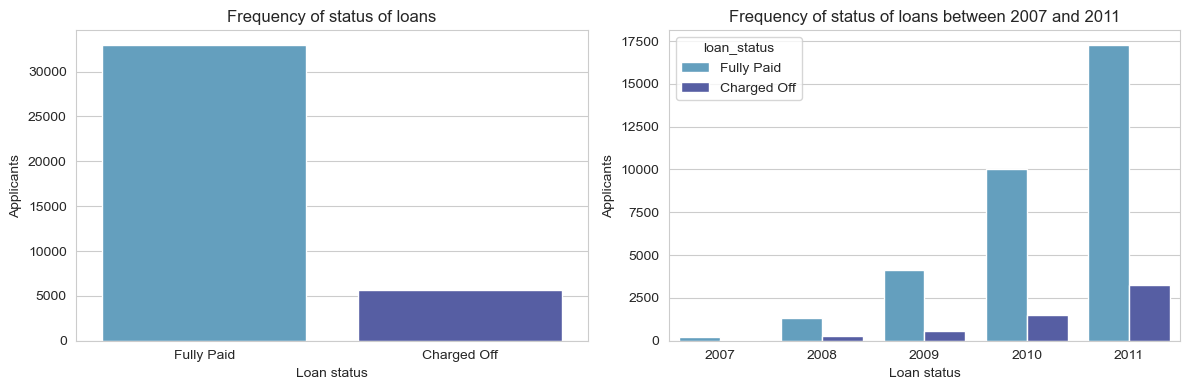

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Plot overall frequency distribution of loan status
sns.countplot(data = df, x = 'loan_status', ax = ax[0])
ax[0].set_title('Frequency of status of loans')
ax[0].set_xlabel('Loan status')
ax[0].set_ylabel('Applicants')

# Plot frequency of distribution of loan status by year
sns.countplot(data = df, x = 'issue_year', hue = 'loan_status', ax = ax[1])
ax[1].set_title('Frequency of status of loans between 2007 and 2011')
ax[1].set_xlabel('Loan status')
ax[1].set_ylabel('Applicants')

plt.tight_layout()
plt.show()

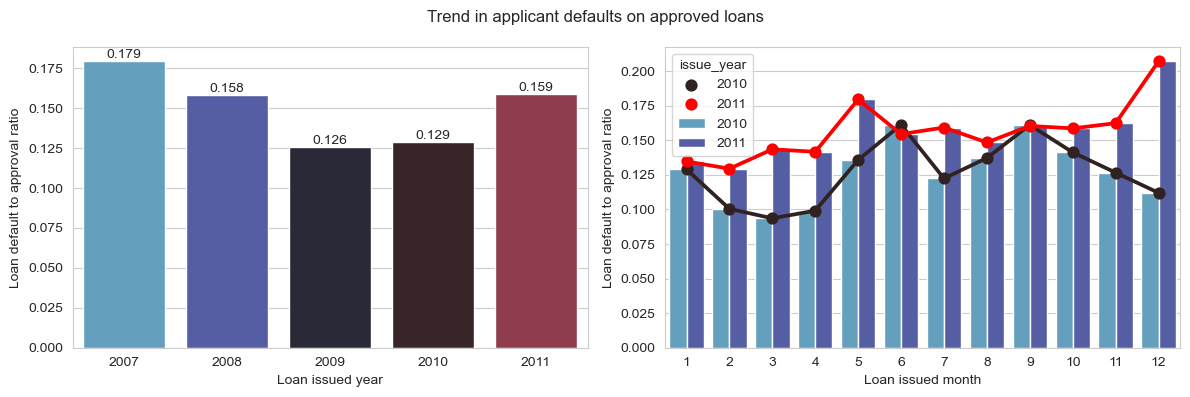

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# plot applicants defaults to approval ratio by year
sns.barplot(data = status_yr[status_yr['loan_status'] == 'Charged Off'], x = 'issue_year', y = 'defaults', ax = ax[0])
ax[0].bar_label(ax[0].containers[-1], fmt='%.3f', label_type='edge')
ax[0].set(xlabel = 'Loan issued year', ylabel = 'Loan default to approval ratio')

# plot applicants defaults to approval ratio by month for year 2010 and 2011
sns.barplot(data = status_mo[status_mo['loan_status'] == 'Charged Off'], x = 'issue_month', y = 'defaults', hue = 'issue_year', ax = ax[1])
sns.pointplot(data = status_mo[status_mo['loan_status'] == 'Charged Off'], x = 'issue_month', y = 'defaults', hue = 'issue_year', ax = ax[1],
              color = 'red', label = None)
ax[1].set(xlabel = 'Loan issued month', ylabel = 'Loan default to approval ratio')

plt.suptitle('Trend in applicant defaults on approved loans')
plt.tight_layout()
plt.show()

Between 2007 and 2011, LendingClub grew applicants from 251 in 2007 to 20,516 in 2011 at a CAGR of over 140 percentage. As the business grew phenominally, the applicant defaults on the loans also increased at 14.5%. The time period coincides with the great recession in 2008. During the time  the leading rate in the  were dropped from 5.1% in 2008 to 3.3% in 2009 remained same for the rest of the considered timeframe.

The rate of defaults dropped steadily until 2010 to 12.9% and spiked to 15.9% in 2011. From the compairsion between the approved loan by month for the two years, we can observed that the defaults were higher for most of the months in 2011. The most constracting observations is in the 4th quarter of the year where the defaults increased steadily in 2011, while gradually dropped in 2010.

*`Questions to explore`*
1. What factors influencing the defaults?
2. What factors drove the sharp increase in defaults in 2011?

(What factors drove divergence in trend in the last quarter of the calender year 2010 and 2011?) <- Not considered.

#### Investigate categorical features

In [17]:
## list categorical features
for c in cat_cols:
    num_uniques = df[c].fillna('').nunique()
    col_type = 'nominal' if c in cat_nom_cols else 'ordinal'
    if num_uniques < 10:
        print(f'({col_type}) {c:20s}: ({num_uniques})    {sorted(df[c].fillna(-1).unique())}')
    else:
        print(f'({col_type}) {c:20s}: ({num_uniques})')

(nominal) home_ownership      : (5)    ['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']
(nominal) verification_status : (3)    ['Not Verified', 'Source Verified', 'Verified']
(nominal) purpose             : (14)
(nominal) title               : (19297)
(nominal) addr_state          : (50)
(ordinal) term                : (2)    [' 36 months', ' 60 months']
(ordinal) grade               : (7)    ['A', 'B', 'C', 'D', 'E', 'F', 'G']
(ordinal) sub_grade           : (35)
(ordinal) emp_length          : (12)
(ordinal) pub_rec_bankruptcies: (4)    [-1.0, 0.0, 1.0, 2.0]
(ordinal) issue_month         : (12)
(ordinal) issue_year          : (5)    [2007, 2008, 2009, 2010, 2011]


Applicates are from all the 50 states in the country. Let inspect the distribution.

In [18]:
def plot_aggregate(data, groupby: list, **kwargs):
    
    title = kwargs.get('title', None)
    xlabel = kwargs.get('xlabel', None)
    ylabel = kwargs.get('ylabel', None)
    axis = kwargs.get('axis', None)
    
    app_agg = pd.DataFrame(data.groupby(by = groupby)['member_id'].count())\
        .sort_values(by = 'member_id', ascending = False).reset_index()
    app_agg.rename(columns = {'member_id' : 'count'}, inplace = True)
    
    if axis is None:
        plt.subplots(1, 1, figsize = (16, 4))
        sns.barplot(data = app_agg, x = groupby[0], y = 'count', hue = 'issue_year')
        if title: plt.title(title)
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
        plt.show()
    else:
        sns.barplot(data = app_agg, x = groupby[0], y = 'count', hue = 'issue_year', ax = axis)
        if title: axis.set_title(title)
        if xlabel: axis.set_xlabel(xlabel)
        if ylabel: axis.set_ylabel(ylabel)
        return axis

def plot_defaults_on_agg(data, groupby:list, **kwargs):
    subset = kwargs.get('subset', None)
    title = kwargs.get('title', None)
    xlabel = kwargs.get('xlabel', None)
    ylabel = kwargs.get('ylabel', None)
    axis = kwargs.get('axis', None)
    
    defaults_by_state = pd.DataFrame(data.groupby(by = groupby)['member_id'].count())\
        .sort_values(by = 'member_id', ascending = False).reset_index()
    defaults_by_state.rename(columns = {'member_id' : 'count'}, inplace = True)
    
    if subset == None:
        subset = list(set(data[groupby[0]].values))
    defaults_by_state = defaults_by_state[defaults_by_state[groupby[0]].isin(subset)]

    P = defaults_by_state.groupby(by = groupby[:2])['count'].sum().reset_index()
    
    loan_issued_dict = {}
    for s in subset:
        S = P[P[groupby[0]] == s]
        loan_issued_dict[s] = {y : S[S[groupby[1]] ==y]['count'].values[0] for y in S[groupby[1]].unique()}
    
    defaults_by_state['defaults'] = defaults_by_state.apply(lambda r: r['count'] / loan_issued_dict[r[groupby[0]]][r[groupby[1]]], axis = 1)
    defaults_by_state.sort_values(by = 'defaults', ascending = False, inplace = True)
        
    if axis is None:
        plt.subplots(1, 1, figsize = (16, 4))
        sns.barplot(data = defaults_by_state[defaults_by_state['loan_status'] == 'Charged Off'], 
                    x = groupby[0], y = 'defaults', hue = groupby[1])
        if title: plt.title(title)
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
        plt.show()
    else:
        sns.barplot(data = defaults_by_state[defaults_by_state['loan_status'] == 'Charged Off'], 
                    x = groupby[0], y = 'defaults', hue = groupby[1], ax = axis)
        if title: axis.set_title(title)
        if xlabel: axis.set_xlabel(xlabel)
        if ylabel: axis.set_ylabel(ylabel)
        return axis

Who are the most defaults amount the top 10 states by applicants in 2011?

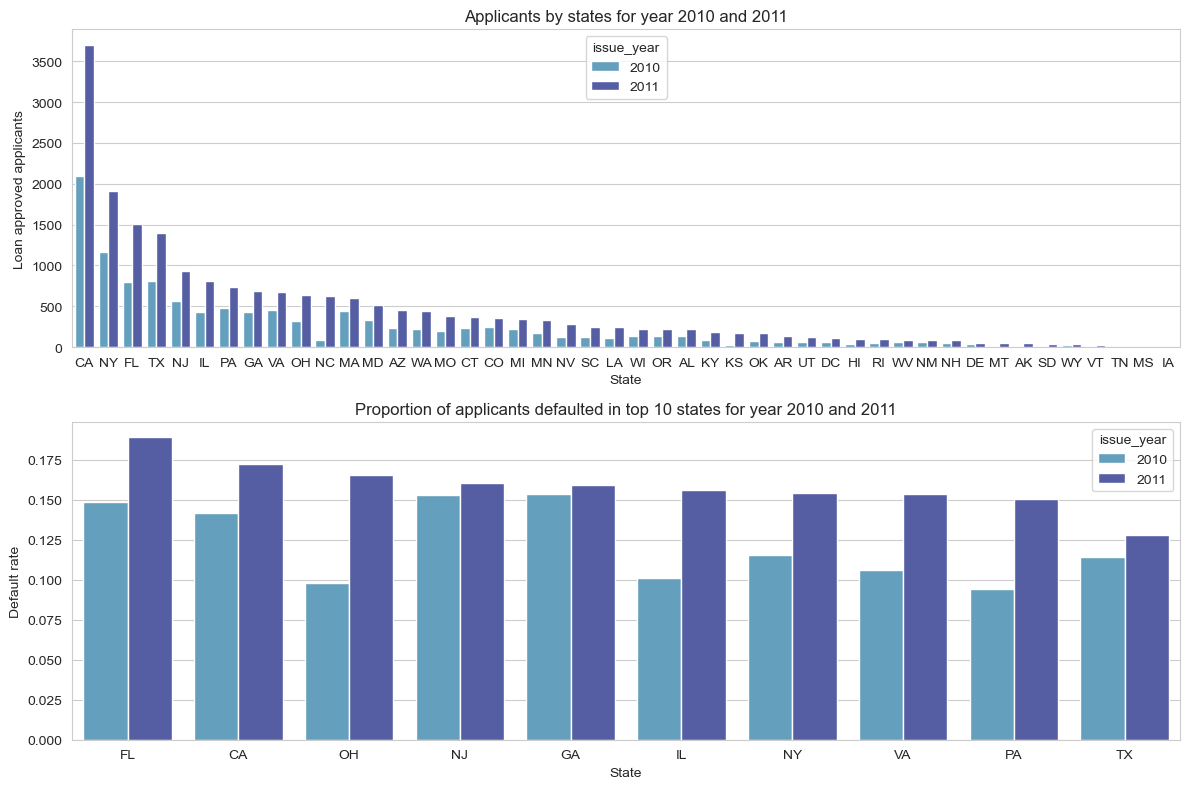

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (12, 8))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['addr_state', 'issue_year'],
    title = 'Applicants by states for year 2010 and 2011',
    xlabel = 'State',
    ylabel = 'Loan approved applicants',
    axis = ax[0]
)

top_10 = pd.DataFrame(df[df['issue_year'] == 2011].groupby(by = ['addr_state'])['member_id'].count().reset_index())\
    .sort_values(by = 'member_id', ascending = False).head(10)['addr_state'].values.tolist()
plot_defaults_on_agg(
    data = df[(df['addr_state'].isin(top_10)) & (df['issue_year'].isin([2010, 2011]))],
    groupby = ['addr_state', 'issue_year', 'loan_status'],
    subset = df[df['issue_year'] == 2011]['addr_state'].value_counts().head(10).index.tolist(),
    title = 'Proportion of applicants defaulted in top 10 states for year 2010 and 2011',
    xlabel = 'State',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

Majority of applicants from the wealthy states in the US including CA, NY, FL, TX, NJ, and IL. LeadingClub might have stated its operations in these area on gradually propogated accorss the country.

The marginal increase is defaults in the year 2011 is uniform accorss the top 10 states by applicants.

Homeo wnership: ['MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']

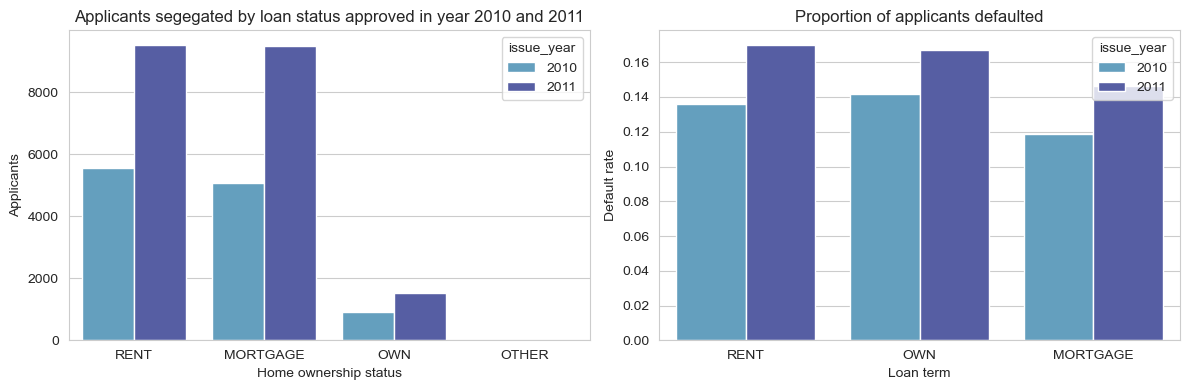

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['home_ownership', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Home ownership status',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['home_ownership', 'issue_year', 'loan_status'],
    subset = ['RENT', 'MORTGAGE', 'OWN'],
    title = 'Proportion of applicants defaulted',
    xlabel =  'Loan term',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

In the year 2010 and 2011, the OTHER category for home ownershiper is 2 and 1 respectively. It seems the field in an application form made manadatory to avoid OTHER category applicants. 

The proporational increase in homeownership is fairly consistanct between the years.

verification_status: ['Not Verified', 'Source Verified', 'Verified']
Indicates if income was verified by LC, not verified, or if the income source was verified

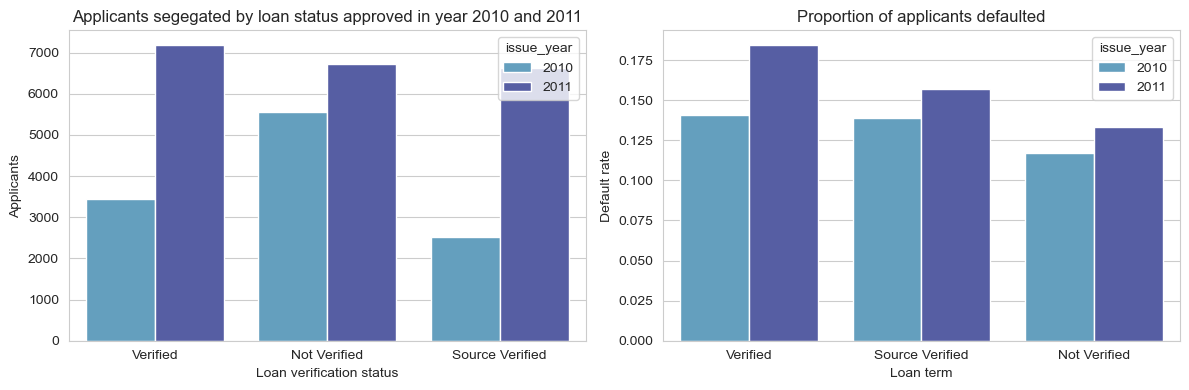

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['verification_status', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Loan verification status',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['verification_status', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel =  'Loan term',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

In 2011, applicants where income verified by LendingClub saw in increase in defaults 

Loan term (term)

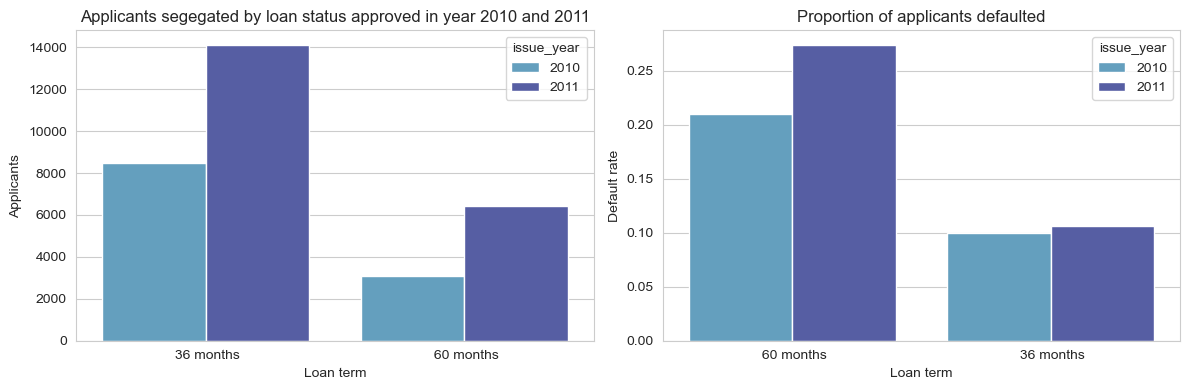

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['term', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Loan term',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['term', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel = 'Loan term',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

The applicants who took loan for a longer term (60 months) saw a larger increase in default. The default rate increased from 21% to 25% among these applicants. However, the applicants are nearly 1/4 of all the applicants in this category.

Grade A-F

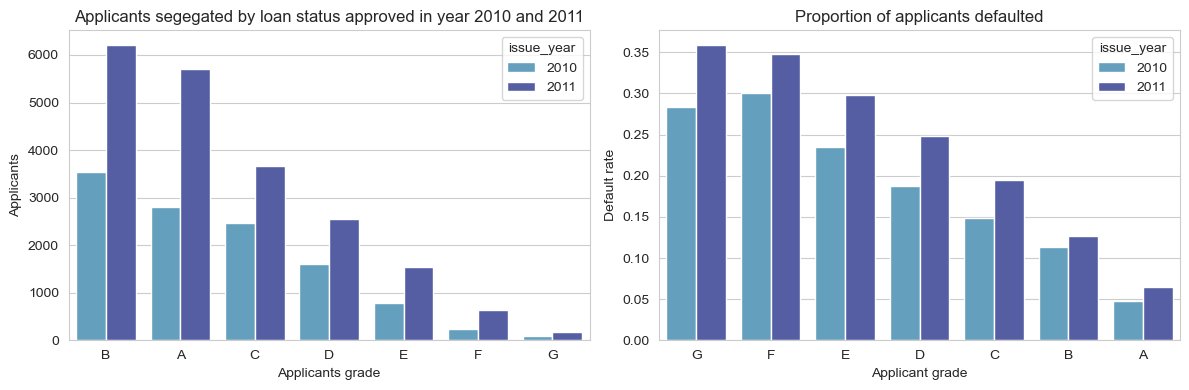

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['grade', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Applicants grade',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['grade', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel = 'Applicant grade',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

The proportion of increase in defaults by grade is still fairly consistant between the two years.

emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

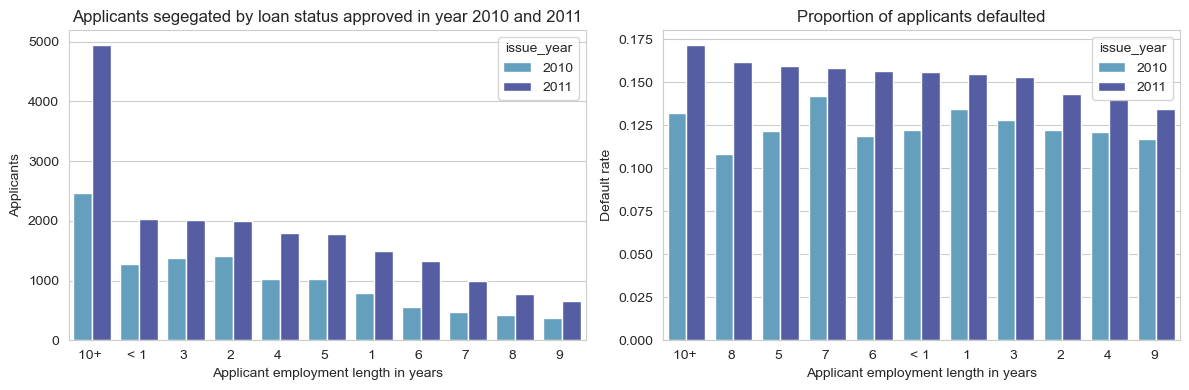

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
df['emp_length'] = df['emp_length'].str.replace('years', '').str.replace('year', '')
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['emp_length', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['emp_length', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

Large number of applicants with more than 10-years got approval of the loan and the proporational increase in default in the group is slightly higher. The large increase in applicants could be affect of great recession.

How are applicants with grade B distribtued against the employment length?

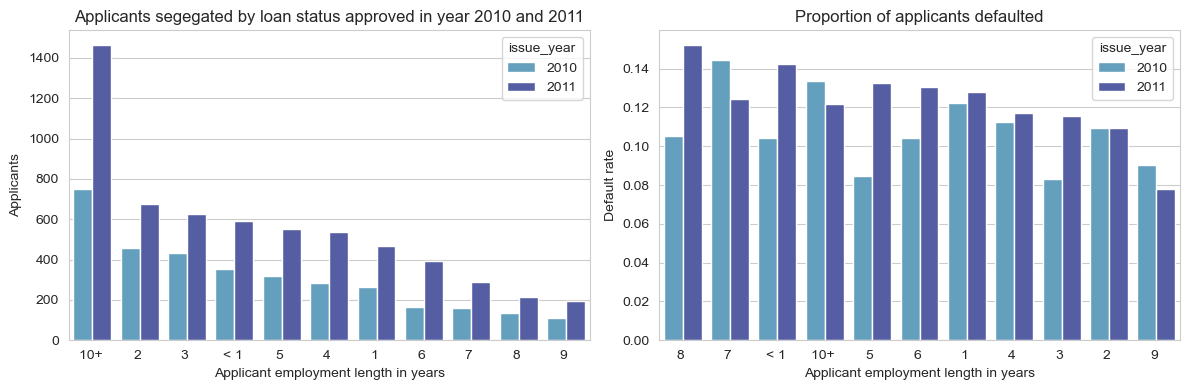

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
D = df.copy()
D = D[D['grade'].isin(['B'])]
plot_aggregate(
    data = D[D['issue_year'].isin([2010, 2011])], 
    groupby = ['emp_length', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = D[(D['issue_year'].isin([2010, 2011]))],
    groupby = ['emp_length', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

Not much be deduced from slicing the applicant with grade B accross the experience.

pub_rec_bankruptcies: Number of public record bankruptcies

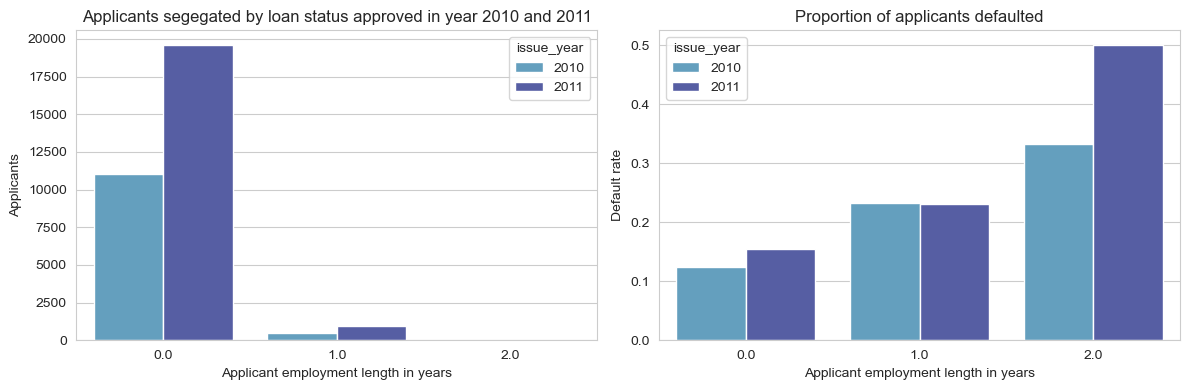

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
plot_aggregate(
    data = df[df['issue_year'].isin([2010, 2011])], 
    groupby = ['pub_rec_bankruptcies', 'issue_year'],
    title = 'Applicants segegated by loan status approved in year 2010 and 2011',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Applicants',
    axis = ax[0]
)

plot_defaults_on_agg(
    data = df[(df['issue_year'].isin([2010, 2011]))],
    groupby = ['pub_rec_bankruptcies', 'issue_year', 'loan_status'],
    title = 'Proportion of applicants defaulted',
    xlabel = 'Applicant employment length in years',
    ylabel = 'Default rate',
    axis = ax[1]
)
plt.tight_layout()
plt.show()

Most of the applicant have no public bankruptcies. And for those who backrupt at least once have fair split between 2010 and 2011.

Group | Sub group

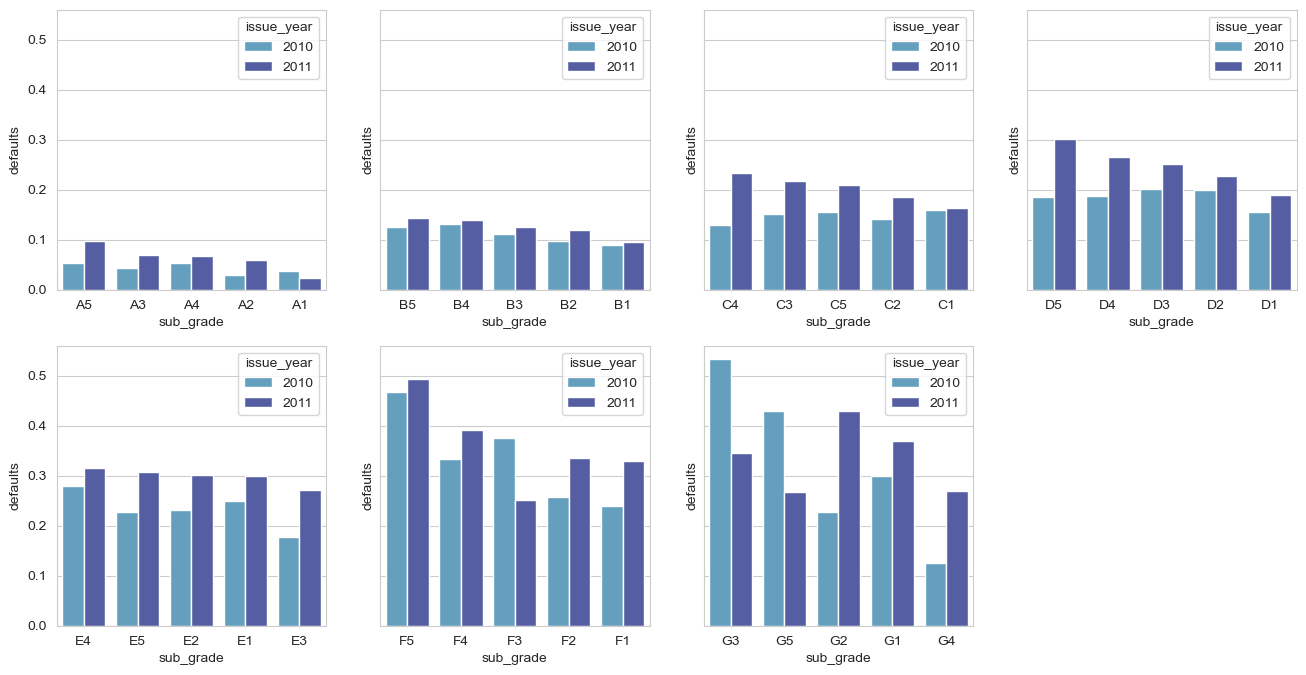

In [27]:
fig, ax = plt.subplots(2, 4, figsize = (16, 8), sharey = True)
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
for idx, _ax in enumerate(zip(ax.flatten())):
    if idx < len(grades):
        plot_defaults_on_agg(
            data = df[(df['issue_year'].isin([2010, 2011])) & (df['grade'] == grades[idx])],
            groupby = ['sub_grade', 'issue_year', 'loan_status'],
            axis = _ax[0]
        )
    else:
        _ax[0].remove()

There is ordinal relationship between the grades and their respective sub-grades. Default rates increases with letter grade and which further increases within the sub-grades. 

The above plots are rate of default.

### Helper functions

In [28]:
# T-test
from scipy.stats import ttest_ind

def run_ttest(data, subset: str, groups:list, on: str, suffix = None, thresh = 0.05):
    assert len(groups) == 2, print(f'Groups passed for the t-test is not in pairs. {groups}')

    group1 = data[data[subset] == groups[0]][on]
    group2 = data[data[subset] == groups[1]][on]
    
    result = ttest_ind(group1, group2)
    qualifier = 'significant' if result.pvalue <= thresh else 'insignifcant'
    print(f'{suffix} T-test: Difference in mean between the two groups is statistically {qualifier}; p-value {result.pvalue:.4f}')

#### Numerical Features

In [29]:
# Lets encode the target
LABEL_TO_INDEX = {'Fully Paid' : 0, 'Charged Off' : 1}
INDEX_TO_LABEL = {v:k for k,v in LABEL_TO_INDEX.items()}

df['loan_status'] = df['loan_status'].map(LABEL_TO_INDEX)
df['loan_status'].value_counts()

0    32950
1     5627
Name: loan_status, dtype: int64

Clean interest rate

In [30]:
df['int_rate'] = df['int_rate'].str.replace('%', '').apply(float) / 100.

- Loan mount: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- Funded amount: The total amount committed to that loan at that point in time.
- Funded amount by investor: The total amount committed by investors for that loan at that point in time.

In [31]:
round(df[num_cols].describe(), 4)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,mths_since_last_delinq
count,38577.0000,38577.0000,38577.0000,38577.0000,38577.0000,3.857700e+04,38577.0000,13672.0000
mean,11047.0254,10784.0585,10222.4811,0.1193,322.4663,6.877797e+04,13.2727,35.8825
std,7348.4416,7090.3060,7022.7206,0.0369,208.6392,6.421868e+04,6.6730,22.0281
min,500.0000,500.0000,0.0000,0.0542,15.6900,4.000000e+03,0.0000,0.0000
25%,5300.0000,5200.0000,5000.0000,0.0894,165.7400,4.000000e+04,8.1300,18.0000
50%,9600.0000,9550.0000,8733.4400,0.1171,277.8600,5.886800e+04,13.3700,34.0000
75%,15000.0000,15000.0000,14000.0000,0.1438,425.5500,8.200000e+04,18.5600,52.0000
max,35000.0000,35000.0000,35000.0000,0.2440,1305.1900,6.000000e+06,29.9900,120.0000


Correlation among the numerical features

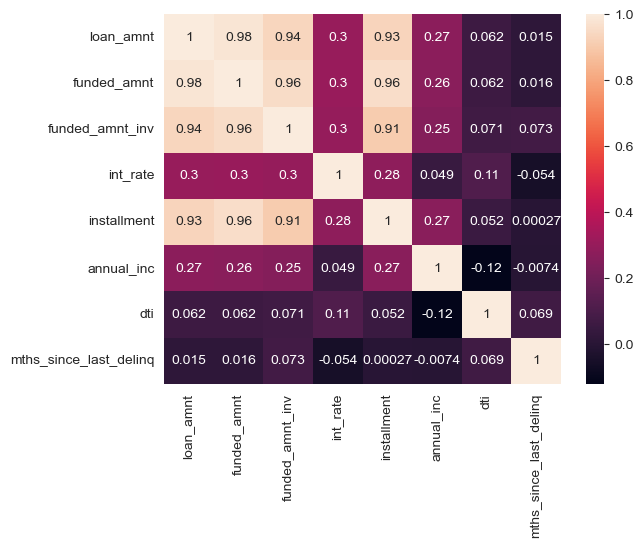

In [32]:
sns.heatmap(data = df[num_cols].corr(), annot= True)
plt.show()

It is not suprise that loan amount, funded amount, funded amount inventory and installment are correlated related strongly.

Loan amount

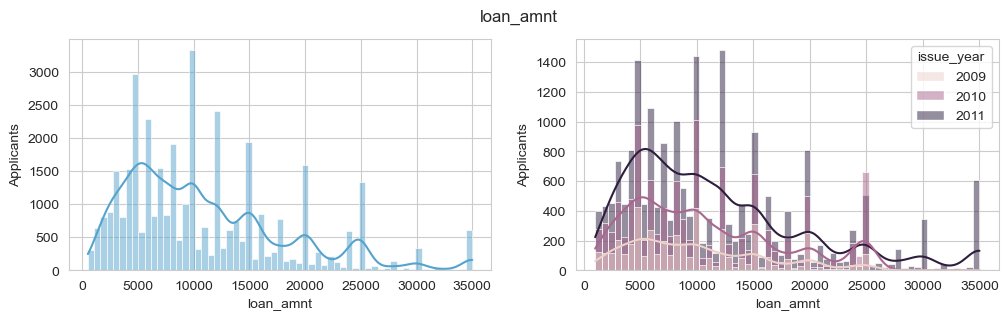

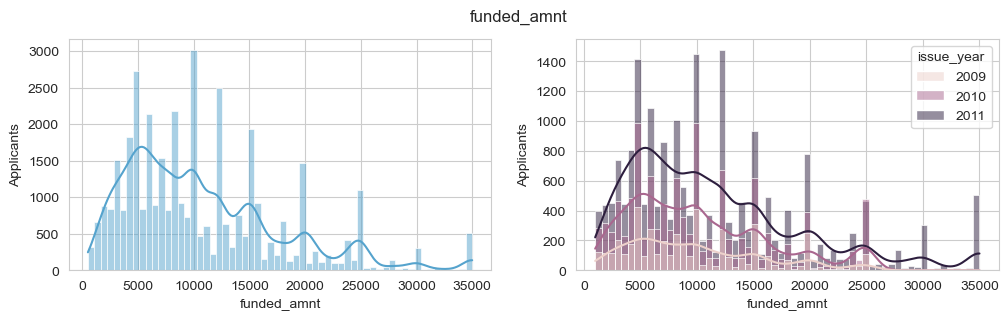

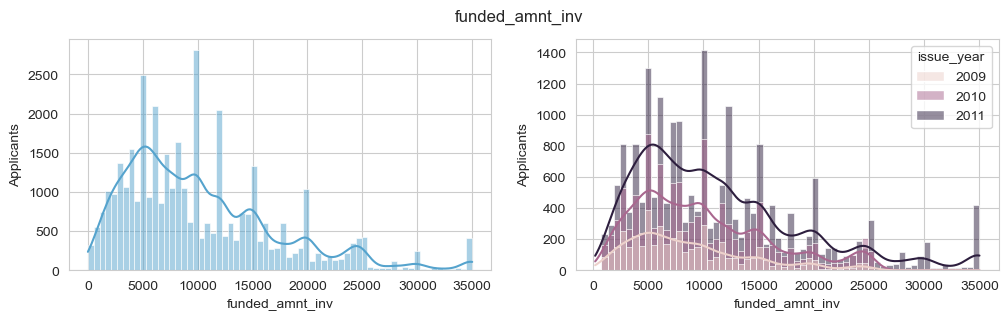

In [33]:
for f in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']:
    fig, ax = plt.subplots(1, 2, figsize = (12, 3))
    sns.histplot(data = df, x = f, kde = True, ax = ax[0])
    sns.histplot(data = df[df['issue_year'].isin([2009, 2010, 2011])], x = f, hue = 'issue_year', kde = True, ax = ax[1])
    ax[0].set(xlabel = f, ylabel = 'Applicants')
    ax[1].set(xlabel = f, ylabel = 'Applicants')
    plt.suptitle(f)
    plt.show()

Secured in median funds the applicant asked from LeandingClub over the years:


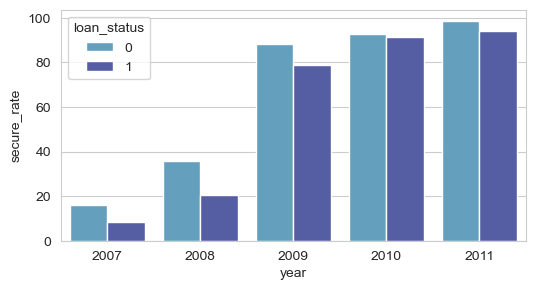

In [34]:
# Loan secured of an initial ask
med_funds = round(df.groupby(by = ['issue_year', 'loan_status'])['loan_amnt', 'funded_amnt', 'funded_amnt_inv'].median().reset_index())
print('Secured in median funds the applicant asked from LeandingClub over the years:')
secured_loan = []
for status in [0, 1]:
    for y in range(2007, 2012):
        row = med_funds[(med_funds['loan_status'] == status) & (med_funds['issue_year'] == y)]
        if row.empty:
            secured_loan.append((y, 0, status))
            continue
        secure_rate =(100 * row['funded_amnt_inv'] / row['loan_amnt']).values[0]
        secured_loan.append((y, secure_rate, status))
    
plt.subplots(1,1, figsize = (6, 3))
sns.barplot(data = pd.DataFrame(secured_loan, columns = ['year', 'secure_rate', 'loan_status']), 
            x = 'year', y = 'secure_rate',
            hue = 'loan_status')
plt.show()

Large portion of loan amounts are rounded to nearest 1000 dollars. 
There is clear spike on multiple of 5000 including 5k, 10k, 15k, 20k, 25k, 35k. The distribution is right skewed.

The distribution pattern for all the three amount is same. From the applicant initial ask to funded, the amount gradually drops.
Over the years, the loan approval rate in terms of initial funds asked by the borrow increased steadily reaching as high as 99.75% in 2011. While the rate was 91.70% in 2010.

The separation between fully paid and defaulted applications is marginal. The consumers who defaulted recevied lower than the asked in compaision to who fully paid.

Interest rate

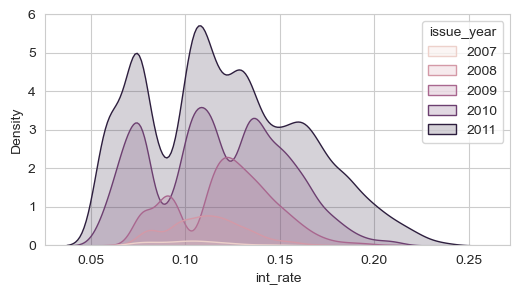

In [35]:
plt.subplots(1,1, figsize = (6, 3))
sns.kdeplot(data = df, x = 'int_rate', hue = 'issue_year', fill = True, alpha = 0.2)
plt.show()

Interest rate charged to the borrower seems to follow bimodal distribution in 2009 and tri-model in 2010 and 2012. The number of applicants who secured with higher interest rates (more than 20%) increased consideably in 2011.

We can split the interest rate in group by interval and investigate defaults.

In [36]:
# group interest rate
def group_int_rate(x):
    interval = 0.075
    if x <= interval:
        return 1
    elif x <= 2*interval:
        return 2
    elif x <= 3*interval:
        return 3
    elif x <= 4*interval:
        return 4
    elif x <= 5*interval:
        return 5
    else:
        return 6
    
df['int_rate_gp'] = df['int_rate'].apply(lambda x: group_int_rate(x))
df['int_rate_gp'].value_counts()

2    25211
3     7931
1     5370
4       65
Name: int_rate_gp, dtype: int64

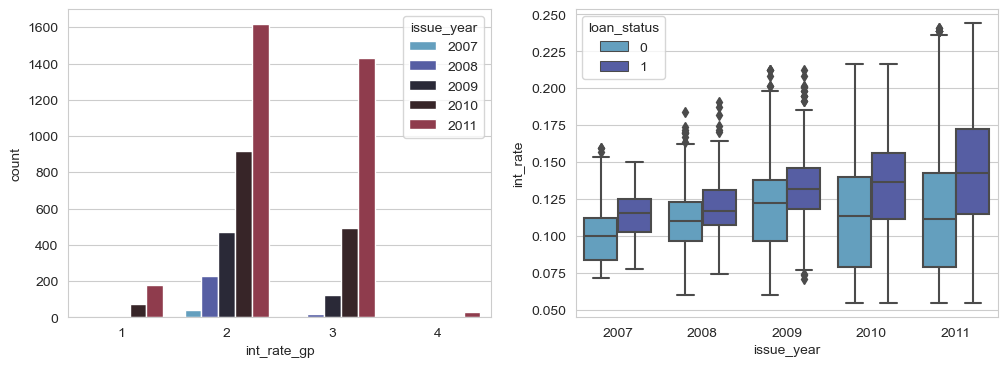

In [37]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))
sns.countplot(data = df[df['loan_status'] == 1], x = 'int_rate_gp', hue = 'issue_year', ax = ax[0])
sns.boxplot(data = df, y = 'int_rate', x = 'issue_year', hue = 'loan_status', ax = ax[1])
plt.show()

Interest rate charge to the defaulted borrowers is considerably higher. 

It might be possible that the management aware of the risk by other factors such as credit score and charged higher interest rate. The median difference is as much as 5% in 2011.

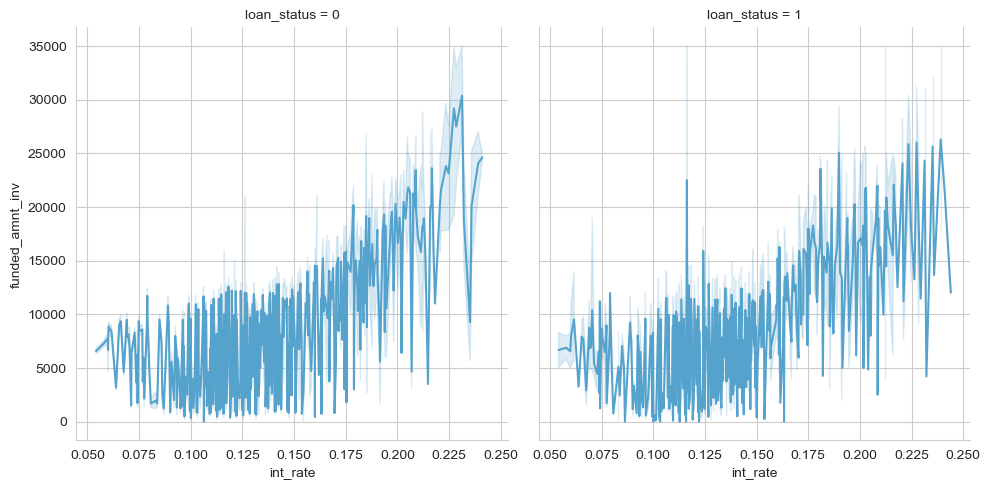

In [38]:
## Loan amount vs. interest rate by laon status
df['unsecured_amount'] = df['funded_amnt'] - df['funded_amnt_inv']
sns.relplot(data = df, x = 'int_rate', y = 'funded_amnt_inv', col = 'loan_status', kind = 'line')
plt.show()

Although it is noisy line plot, the trend is telling. The interest rate increases with an increase in amount borrowed. The trend is exponential in nature.

Annual income (annual_inc)

In [39]:
# annual income
def annual_income(n):
    if n <= 50000:
        return 'low'
    elif n > 50000 and n <=100000:
        return 'medium'
    elif n > 100000 and n <=150000:
        return 'high'
    else:
        return 'very high'

df['annual_inc_gp'] = df['annual_inc'].apply(lambda x: annual_income(x))

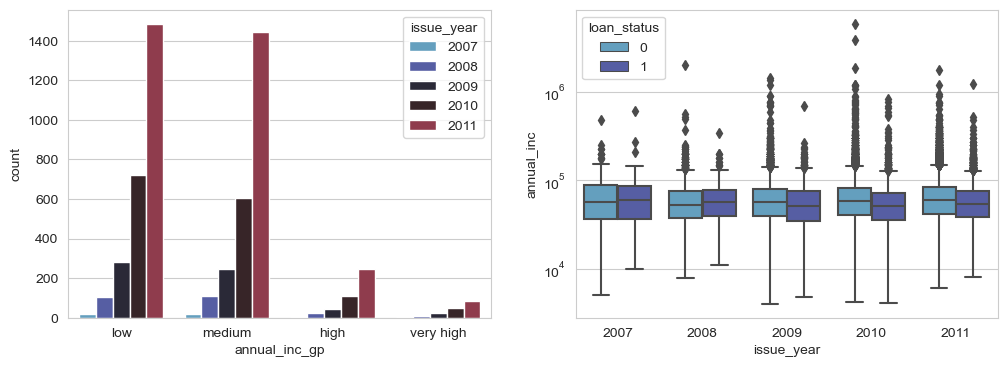

In [40]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))
sns.countplot(data = df[df['loan_status'] == 1], x = 'annual_inc_gp', hue = 'issue_year', ax = ax[0])
sns.boxplot(data = df, y = 'annual_inc', x = 'issue_year', hue = 'loan_status', ax = ax[1])
ax[1].set_yscale('log')
plt.show()

In [41]:
for y in range(2007, 2012):
    run_ttest(data=df[df['issue_year'] == y], subset='loan_status', groups = [0, 1], on = 'annual_inc', suffix = y)

2007 T-test: Difference in mean between the two groups is statistically insignifcant; p-value 0.3129
2008 T-test: Difference in mean between the two groups is statistically insignifcant; p-value 0.8860
2009 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0100
2010 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0031
2011 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0000


The difference in mean between the applicants who defaults and fully paid is statisically significant in year 2009, 2010, and 2011.

Secured fund amount to annual income ratio

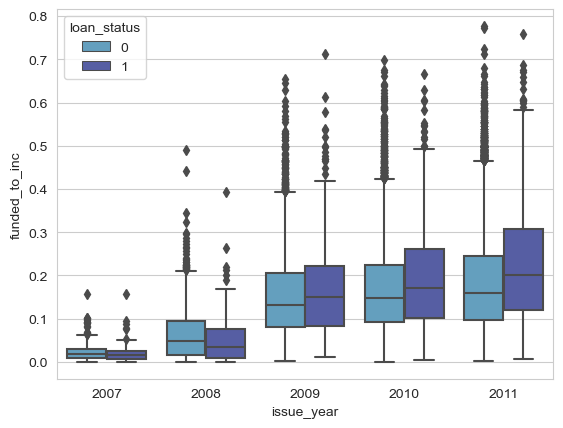

In [42]:
df['funded_to_inc'] = df['funded_amnt_inv'] / df['annual_inc']
sns.boxplot(data = df, y = 'funded_to_inc', x = 'issue_year', hue = 'loan_status')#, ax = ax[1])
plt.show()

In [43]:
for y in range(2007, 2012):
    run_ttest(data=df[df['issue_year'] == y], subset='loan_status', groups = [0, 1], on = 'funded_to_inc', suffix = y)

2007 T-test: Difference in mean between the two groups is statistically insignifcant; p-value 0.8582
2008 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0007
2009 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0124
2010 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0000
2011 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0000


Funded amount to the borrowers income increased over the years. It might the effect of expansion process. With reaching more customers between 2009 and 2011, the LeadingClub started giving loan their nominal 0.15 times for annual income to 0.2 times in 2011. T-test also confirms that the mean between the applicants defaulted and the fully paid is statistically significant. Note that some of the loans were as high as 80% of the annual income.

dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

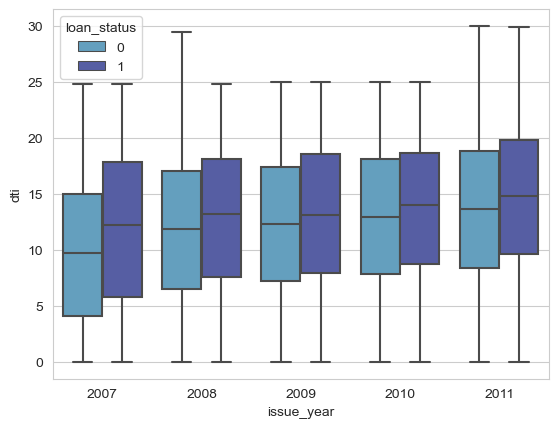

In [44]:
#df['funded_to_inc'] = df['funded_amnt_inv'] / df['annual_inc']
sns.boxplot(data = df, y = 'dti', x = 'issue_year', hue = 'loan_status')#, ax = ax[1])
plt.show()

In [45]:
for y in range(2007, 2012):
    run_ttest(data=df[df['issue_year'] == y], subset='loan_status', groups = [0, 1], on = 'dti', suffix = y)

2007 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0310
2008 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0306
2009 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0153
2010 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0046
2011 T-test: Difference in mean between the two groups is statistically significant; p-value 0.0000


The mean difference of dti among the applicant group is observed among all the years.

Months since last delinquency

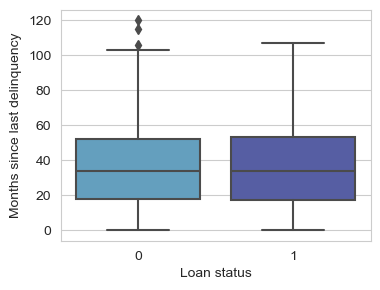

Months since last delinquency shows not significant variance between the loan status
None T-test: Difference in mean between the two groups is statistically insignifcant; p-value 0.5296


In [46]:
# mths_since_last_delinq
plt.subplots(1, 1, figsize = (4, 3))
D = df[~df['mths_since_last_delinq'].isna()]
sns.boxplot(data = D, y = 'mths_since_last_delinq', x = 'loan_status')
plt.ylabel('Months since last delinquency')
plt.xlabel('Loan status')
plt.show()

# print count over loan status
# print('Count over loan status')
# print(df[~df['mths_since_last_delinq'].isna()]['loan_status'].value_counts())

# Run t-test to check if the observation
print('Months since last delinquency shows not significant variance between the loan status')
run_ttest(data=D, subset='loan_status', groups = [0, 1], on = 'mths_since_last_delinq')

Purpose

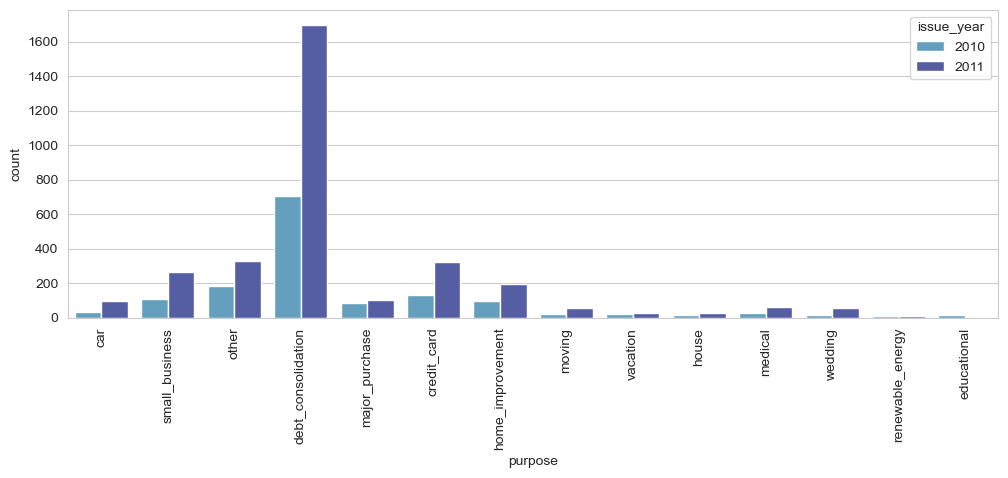

In [47]:
plt.subplots(1, 1, figsize = (12, 4))
sns.countplot(data = df[df['issue_year'].isin([2010, 2011]) & df['loan_status'] == 1], 
              hue = 'issue_year',
              x = 'purpose')
plt.xticks(rotation = 90)
plt.show()

Applicants who took loans on the purpose for debt consoliation, small business, credit card, other, and home improvement, saw greater increase in defults in 2011 compared to 2010. Medical and wedding purpose loans also saw increase in defaults.

Inspect the select puposes with fund to income ratio

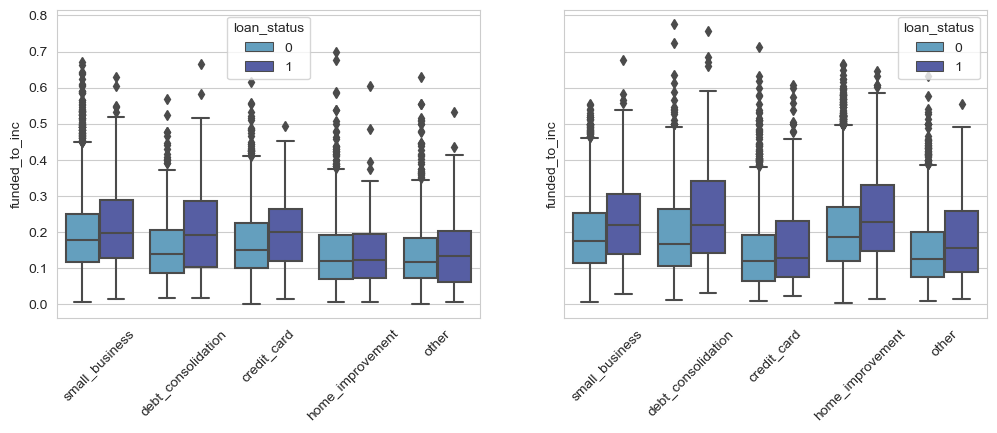

In [48]:
selected_purpose = ['small_business', 'debt_consolidation', 'credit_card', 'home_improvement', 'other']
fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = True)
sns.boxplot(data = df[(df['issue_year'] == 2010) & df['purpose'].isin(selected_purpose)], 
            x = 'purpose', y = 'funded_to_inc', hue = 'loan_status', ax = ax[0])
sns.boxplot(data = df[(df['issue_year'] == 2011) & df['purpose'].isin(selected_purpose)], 
            x = 'purpose', y = 'funded_to_inc', hue = 'loan_status', ax = ax[1])
for i in [0, 1]:
    ax[i].set(xlabel = "")
    ax[i].set_xticklabels(labels = selected_purpose, rotation = 45)
plt.show()

On average, the those defaulted applicants are funded for lower annual income accross the purpose stated by them.

Funded to income ratio on loan tenure

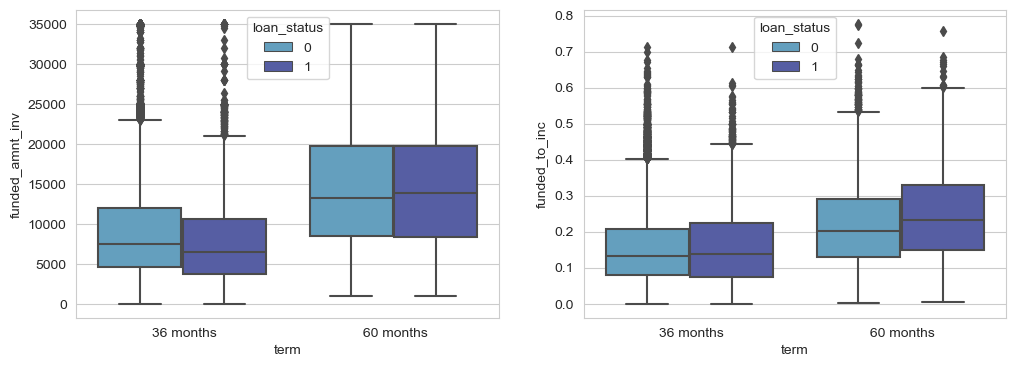

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
sns.boxplot(data = df, x = 'term', y = 'funded_amnt_inv',  hue = 'loan_status', ax = ax[0])
sns.boxplot(data = df, x = 'term', y = 'funded_to_inc',  hue = 'loan_status', ax = ax[1])
plt.show()

Applicants who defaulted took short term loan (36 months).
While those who took long term loan (60 months) are defaulted when the funded amount is more than 0.2 of there income on average.

#### Summary

In the exploratory data analysis we aim to investigate the factors influcing the consumer defualts on the loan secured from the LendingClub. The two main questions we investigated are (1) indentify factors driving the defaults and (2) what shifted to increase in the defaults from 2010 to 2011. These investigation may assists in creating strategies for LeadingClub to implement stingent loan approval checklist to minimize loss due to consumer defaults.

Here are the key observerations to answers the above question:
1. The primary factor in the loan default is those applicants who secured loans on debt consolidation followed by small businesses, credit cards, home improvements, and others. (Note that the records might have combined in others that do not fit in any of the rest 11 categories.)
2. Divergence between the mean funded to annual income ratio for the applicants' defaults is higher. While the interest rate charged to them is also higher. It seems that the organization has some corollary framework to assign interest rates on the risk they are acquiring from offering loans to those risky applicants. This is a normal process in the lending business.
3. Contrary to the above observation, it is observed that there exists a non-linear (exponential) relationship between the interest charge and the funded amount irrespective of the riskiness of the default. Interest rates are as high as 25% funded in 2011, which is about 500bps higher than in 2010.
4. Over the years, as the business expanded, the risk appetite of it also increased. Until 2009, the funded amount to annual income ratio of the applicant was 0.15, and this increased to 0.2 in 2011.
5. Grading system employed by the business is effective. It is evident from the fact that with an increase in letter grades from A to G, the default rate increased. The sub-grades also follow the same trend. The number of approval also gradually dropped to a couple of hundred approval in grade G.
6. The business implementation of the verification process can be improved. The default rate for those applicants' income verified by the business, and the income source verified is significantly higher than non-verified. This observation is contrary to normal wisdom. Loans that are verified are expected to have low defaults than non-verified ones. It is likely that the verification could be the aftermath of delinquency/default. In that case, the verification process should be integrated into the application process.
7. Long-term loans of 60 months have higher defaults than 36 months. Applicants who defaulted took a short-term loan (36 months). While those who took long-term loans (60 months) defaulted when the funded amount is more than 0.2 of their income on average.

### END